In [1]:
import sys
import json
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from ete3 import NCBITaxa
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
sys.path.append('/davidb/yatirsolan/scripts/python/bio_utilities/')
import phylogenetics
from phylogenetics import family_to_phylum
import databases
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-white')

In [2]:
ncbi = NCBITaxa()
tax_map_dic = phylogenetics.taxid_mapping() 

##### Auxilary functions
1. **filter_distribution:**
    - Filters data from none-WGS data.
    - Filters WGS GCAs on which the taxonomic data isn't proper.
    - Filters families on which there is small number of representative families within WGS. The default threshold value I choosed is 50.
    
2. **family_to_phylum:**
    - The function takes a family name, and returns its phylum name

In [3]:
def filter_distribution(subtype_dic, stat_thresh=50):
    tax_appearance_df = pd.read_table(r'/davidb/yatirsolan/ncbi_taxids/wgs_taxids.tsv', dtype={col:str for col in ['assembly', 'phylum', 'class', 'order', 'family', 'genus', 'species']})
    tax_missing_GCAs = set(tax_appearance_df[tax_appearance_df.family.isna()].assembly) # GCA accessions on which for some reasons lacking decent taxonmic annotation.
    tax_appearance_df = tax_appearance_df[~(tax_appearance_df.family.isna())] # filtering all the accessions that have Nan in their family taxIDs.

    family_counts_dict = tax_appearance_df.family.value_counts().to_dict() # a dictionary that counts all the families appearances, so that keys are family taxIDs, and values are their count appearances.
    under_thresh_fmily_taxIDs = dict(filter(lambda item: item[1] < stat_thresh, family_counts_dict.items())).keys() # taxIDs which have less than the stat_threshold appearances in WGS data.
    under_thresh_fmily_names = {phylogenetics.taxid_to_name(fmly_taxID) for fmly_taxID in under_thresh_fmily_taxIDs} # converting the taxIDs into taxonomial names, and making the array -> python's set.
    subtype_dic = dict(filter(lambda items:items[0] not in under_thresh_fmily_names, subtype_dic.items())) # filtering from the results families that don't enough represntation in the data.

    for fmly, contigs in subtype_dic.items():
        filtered_contigs = list(filter(lambda cntg: databases.genomic_source_classifire(cntg)=='WGS', contigs)) # filters all the contigs from non-wgs sources.
        filtered_GCAs = {databases.gca_from_accession(contig) for contig in filtered_contigs} # converting all contigs into GCA accessions, and uniqueing into a python's set.
        filtered_GCAs = list(filter(lambda gca:gca not in tax_missing_GCAs, filtered_GCAs)) # filtering all GCA accession which were found to be lacking decent taxonmic annotation.
        taxID = phylogenetics.name_to_taxid(fmly) 
        subtype_dic[fmly] = len(filtered_GCAs)/(tax_appearance_df.values == str(taxID)).sum() # creating the ratio - the count of acessions with system devided by all acessions of a given family.
    subtype_dic = dict(sorted(subtype_dic.items(), key=lambda items:items[1], reverse=True)) # sorting subtype dict so that the family with higher systems will appear first.
    return subtype_dic

**Obtaining the data that has been found**  -
The pickle file are the final results of the pipeline.

In [4]:
T3SS_main_distribution_dic = pickle.load(open(r'/davidb/yatirsolan/data_presentation/family/T3SS/review_family_T3SS_systems_distribution.pkl','rb'))
T3SS_family_distribution = {subtype:filter_distribution(subtype_dist_dic) for subtype, subtype_dist_dic in T3SS_main_distribution_dic.items()}

T4SS_main_distribution_dic = pickle.load(open(r'/davidb/yatirsolan/data_presentation/family/T4SS/review_family_T4SS_systems_distribution.pkl','rb'))
T4SS_family_distribution = {subtype:filter_distribution(subtype_dist_dic) for subtype, subtype_dist_dic in T4SS_main_distribution_dic.items()}

T6SS_main_distribution_dic = pickle.load(open(r'/davidb/yatirsolan/data_presentation/family/T6SS/review_family_T6SS_systems_distribution.pkl','rb'))
T6SS_family_distribution = {subtype:filter_distribution(subtype_dist_dic) for subtype, subtype_dist_dic in T6SS_main_distribution_dic.items()}

In [5]:
def phylogenetic_barplot_ax(ax, subtype_dic, limits=None, wdth=.8, rotation=45):

    labels = list(subtype_dic.keys())
    values = list(subtype_dic.values())
    phylums = {family_to_phylum(family_name, tax_map_dic) for family_name in labels}
    color_dict = json.load(open(r'/davidb/yatirsolan/thesis_work/figures/colors/phyla_colors_pallete.json'))
    color_dict = dict(filter(lambda items:items[0] in phylums, color_dict.items()))

    if limits:
        ax.set_xlim(left=limits[0], right=limits[1])
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_visible(True)

    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(labelcolor='black', labelsize=7.25, width=1, length=5, color='black')
    
    ax.bar(x=labels, 
           height=values, 
           color=[color_dict.get(family_to_phylum(fmily_nme, tax_map_dic)) for fmily_nme in labels], 
           label=[family_to_phylum(fmily_nme, tax_map_dic) for fmily_nme in labels], 
           width=wdth)

    ax.set_xticklabels(labels=labels, rotation=rotation, rotation_mode='anchor', ha='right')

    ax.set_ylabel(ylabel='System appearance ratio')

    for i in np.arange(len(labels)):
        ax.text(x=labels[i],
                y=values[i]+.0125, 
                s=round(values[i], 3 if (values[i] < .01) else 2), 
                size=6.3,
                rotation=rotation,
                rotation_mode='anchor',
                ha='left')

/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/powerapps/share/python-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used togethe

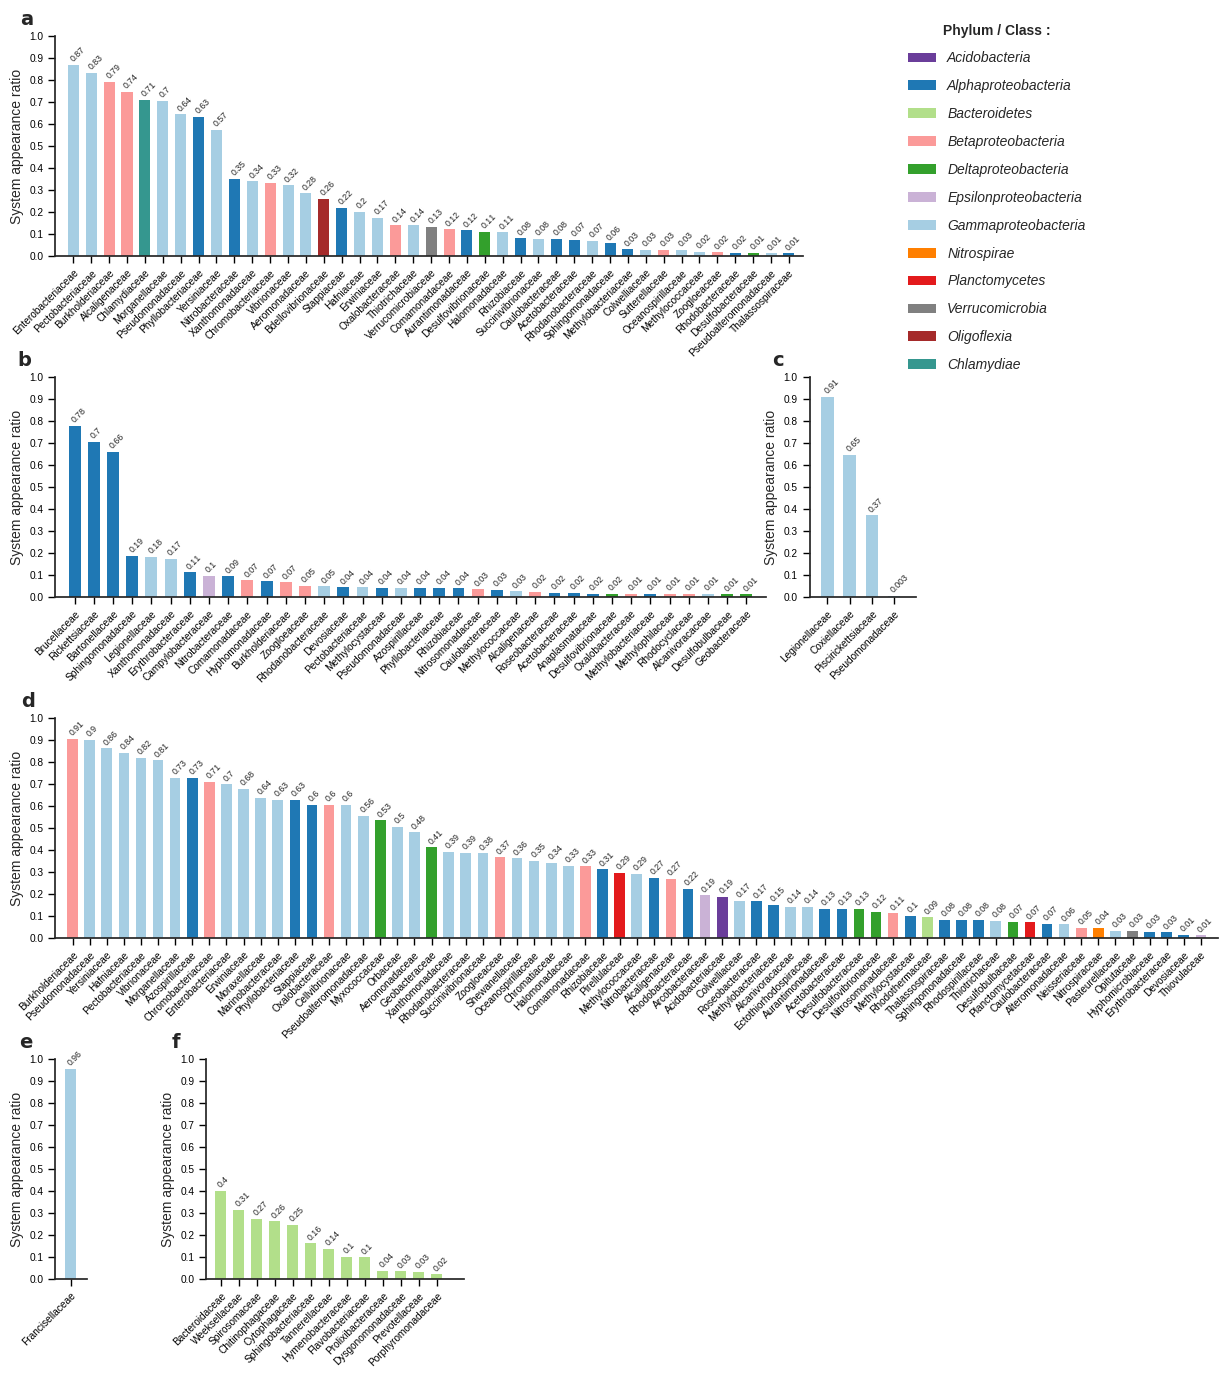

In [7]:
fig = plt.figure(figsize=(15, 25)) 
plt.subplots_adjust(hspace=.55)
ax1 = plt.subplot2grid((6, 31), (0, 0), colspan=20)
ax2 = plt.subplot2grid((6, 31), (1, 0), colspan=19)
ax3 = plt.subplot2grid((6, 31), (1, 20), colspan=3)
ax4 = plt.subplot2grid((6, 31), (2, 0), colspan=31)
ax5 = plt.subplot2grid((6, 31), (3, 0), colspan=1)
ax6 = plt.subplot2grid((6, 31), (3, 4), colspan=7)

T3SS = T3SS_family_distribution.get('T3SS')
T3SS = dict(filter(lambda items:items[1] >= 0.01, T3SS.items()))

phylogenetic_barplot_ax(ax1, subtype_dic=T3SS, limits=(-1,40.8), wdth=.62)
ax1.text(x=-3, y=1.05, s='a', size=14, fontweight='bold', fontfamily='DejaVu Sans')

# --------------------------------------------------

T4SSA = T4SS_family_distribution.get('T4SSA')
T4SSA = dict(filter(lambda items:items[1] >= 0.01, T4SSA.items()))
T4SSB = T4SS_family_distribution.get('T4SSB')

phylogenetic_barplot_ax(ax2, subtype_dic=T4SSA, limits=(-1,36), wdth=.62)
ax2.text(x=-3, y=1.05, s='b', size=14, fontweight='bold', fontfamily='DejaVu Sans')

phylogenetic_barplot_ax(ax3, subtype_dic=T4SSB, limits=(-.8,4), wdth=.57)
ax3.text(x=-2.5, y=1.05, s='c', size=14, fontweight='bold', fontfamily='DejaVu Sans')

# --------------------------------------------------

T6SSi   = T6SS_family_distribution.get('T6SSi')
T6SSi   = dict(filter(lambda items:items[1] >= 0.01, T6SSi.items()))
T6SSii  = T6SS_family_distribution.get('T6SSii')
T6SSii  = dict(filter(lambda items:items[1] >= 0.01, T6SSii.items()))
T6SSiii = T6SS_family_distribution.get('T6SSiii')
T6SSiii = dict(filter(lambda items:items[1] >= 0.01, T6SSiii.items()))

phylogenetic_barplot_ax(ax4, subtype_dic=T6SSi, limits=(-1,67), wdth=.62)
ax4.text(x=-3, y=1.05, s='d', size=14, fontweight='bold', fontfamily='DejaVu Sans')

phylogenetic_barplot_ax(ax5, subtype_dic=T6SSii, limits=(-.64,.69), wdth=.45)
ax5.text(x=-2.2, y=1.05, s='e', size=14, fontweight='bold', fontfamily='DejaVu Sans')

phylogenetic_barplot_ax(ax6, subtype_dic=T6SSiii, limits=(-.8,13.5), wdth=.62)
ax6.text(x=-2.7, y=1.05, s='f', size=14, fontweight='bold', fontfamily='DejaVu Sans')

families = set(itertools.chain.from_iterable(map(lambda x:x.keys(), [T3SS, T4SSA, T4SSB, T6SSi, T6SSii, T6SSiii])))
phyla = set(map(family_to_phylum, families))
color_dict = json.load(open(r'/davidb/yatirsolan/thesis_work/figures/colors/phyla_colors_pallete.json'))
color_dict = dict(filter(lambda items:items[0] in phyla, color_dict.items()))

legend_elements = [Patch(facecolor=clr, label=pylm) for pylm, clr in color_dict.items()]
fig.legend(handles=legend_elements,
           bbox_to_anchor = (.82,.89),
           prop={'style':'italic'},
           frameon=True, 
           facecolor='white', 
           shadow=False, 
           labelspacing=1, 
           framealpha=.85, 
           edgecolor='white', 
           fancybox=False).set_title(title='Phylum / Class :', prop={'family':'sans', 'weight':'bold', 'style':'normal', 'size':10})

plt.tight_layout()
fig.savefig('figure4.svg', bbox_inches='tight')
fig